## Notebook for determining the camera pose from an image
## Cuaderno para determinar la pose de la cámara dada una imagen

In [31]:
origin_bottom = (0, 0, 0)
origin_top = (0, -20, 0)

right_top = (73.1, -20, 0)
right_bottom = (73.1, 0, 0)

back_top = (0, -20, 50)
back_bottom = (0, 0, 50)

back_right_top = (73.1, -10, 50)
back_right_bottom = (73.1, 0, 50)

known_points_dict = {
    #'orange': right_top, # left top
    #'blue': right_bottom, # left bottom
    #'green': origin_bottom, # origin bottom
    #'purple': origin_top, # origin top
    #'pink': back_top, # back top
    #'yellow': back_bottom, # back bottom
    'yellow-top': back_top,
    'yellow-bottom': back_bottom,
    'green-top': origin_top,
    'green-bottom': origin_bottom,
    'blue-top': right_top,
    'blue-bottom': right_bottom,
    'pink-top': back_right_top,
    'pink-bottom': back_right_bottom
}

color_dict = {
    'orange': (
        [0, 100, 100],
        [20, 255, 255]
    ),
    'green': (
        [50, 100, 30],
        [90, 255, 255]
    ),
    'yellow':(
         [15, 100, 100],
         [35, 255, 255]
    ),
    'purple': (
        [370, 50, 50],
        [420, 255, 255]
    ),
    'blue': (
        [100, 120, 20],
        [150, 255, 255]
    ),
    'pink': (
        [140, 50, 30],
        [190, 255, 255]
    )
}

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def validate_point(w, h):
  if w/h < 0.5:
    return False
  if w/h > 1.5:
    return False
  if w<6:
    return False
  if w>50:
    return False
  return True

def get_circularity(con):
  # check if contour is of circular shape
  perimeter = cv2.arcLength(con, True)
  area = cv2.contourArea(con)
  if perimeter == 0:
      #break
      return False
  circularity = 4*math.pi*(area/(perimeter*perimeter))
  x, y, w, h = cv2.boundingRect(con)
  #print (f"perimeter: {perimeter}, area: {area}, circ: {circularity}, pi: {math.pi}, w: {w}, h: {h}")
  return circularity

def detect_round_shape(image, color_lower, color_upper):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define range of color in HSV
    lower_bound = np.array(color_lower, dtype=np.uint8)
    upper_bound = np.array(color_upper, dtype=np.uint8)

    # Threshold the HSV image to get only specified color
    mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

    # Apply morphological operations to clean up the mask (optional)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected_shapes = []
    for contour in contours:
        # Approximate contour to a polygon
        #approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
        # If the shape has a roundness close to a circle
        #print(len(approx))
        #if len(approx) > 2: # You can adjust the threshold for roundness detection
        c = get_circularity(contour)
        min_circularity = 0.5
        if c > min_circularity:
            # Get the bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)
            if validate_point(w, h):
              if w/h >= 0.55 and w/h <=1.55:
                detected_shapes.append((x, y, w, h, c))

    return mask, detected_shapes

def detect_2d_3d_points(img, show_img=False):

  points_2d = []
  points_3d = []

  # Load image
  if img is not None:
    image = img
  else:
    image = take_photo()

  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 1
  font_color = (255, 255, 255)  # White color in BGR
  thickness = 2

  detected_dict = {}
  for color in color_dict.keys():
    detected_dict[color] = []

  for color in color_dict.keys():
    # Define the color range in HSV
    color_lower = color_dict[color][0] # Lower bound of color
    color_upper = color_dict[color][1] # Upper bound of color

    # Detect round shapes
    mask, detected_shapes = detect_round_shape(image, color_lower, color_upper)

    # Draw rectangles around detected shapes
    for (x, y, w, h, c) in detected_shapes:
        if validate_point(w, h):
          score = w*h*c
          detected_dict[color].append((x, y, w, h, c, score))
            
  position_detected_dict = {}
  for color in detected_dict.keys():
        if len(detected_dict[color])==2:
            x0, y0, w0, h0, c0, score0 = detected_dict[color][0]
            x1, y1, w1, h1, c1, score1 = detected_dict[color][1]
            if y0<y1:
                position_detected_dict[f"{color}-top"] = detected_dict[color][0]
                position_detected_dict[f"{color}-bottom"] = detected_dict[color][1]
            else:
                position_detected_dict[f"{color}-top"] = detected_dict[color][1]
                position_detected_dict[f"{color}-bottom"] = detected_dict[color][0]         
  
  # Process detected blobs, keep the most round
  for poscolor in position_detected_dict.keys():
    color = poscolor.split("-")[0]
    x, y, w, h, c, score = position_detected_dict[poscolor]
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(image, f"{color} - {known_points_dict[poscolor]}", (x if x<800 else x-340, y), font, font_scale, font_color, thickness)
    points_2d.append([x+w/2, y+h/2])
    points_3d.append(list(known_points_dict[poscolor]))

  if show_img:
    plt.imshow(image)

  return points_2d, points_3d

In [54]:
# Path to the image to process

IMAGE_PATH_L = "./images/000L.png"
IMAGE_PATH_R = "./images/000R.png"

/var/folders/yr/pvjq_ntj5tjf0860xxz55spr0000gn/T/ipykernel_56326/1146897738.py:34: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 370 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  lower_bound = np.array(color_lower, dtype=np.uint8)
/var/folders/yr/pvjq_ntj5tjf0860xxz55spr0000gn/T/ipykernel_56326/1146897738.py:35: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 420 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  upper_bound = np.array(color_upper, dtype=np.uint8)


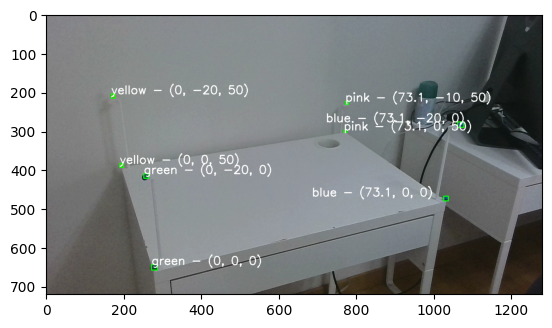

In [55]:
use_this_image = cv2.imread(IMAGE_PATH_L)
use_this_image = cv2.cvtColor(use_this_image, cv2.COLOR_BGR2RGB)

points_2d, points_3d = detect_2d_3d_points(use_this_image, show_img=True)

In [44]:
# Check 2d points
points_2d

[[258.0, 416.0],
 [279.5, 651.0],
 [173.0, 210.5],
 [195.0, 389.0],
 [1070.0, 284.0],
 [1032.0, 474.0],
 [776.0, 228.0],
 [772.0, 301.0]]

In [45]:
# Check corresponding 3d points
points_3d

[[0, -20, 0],
 [0, 0, 0],
 [0, -20, 50],
 [0, 0, 50],
 [73.1, -20, 0],
 [73.1, 0, 0],
 [73.1, -10, 50],
 [73.1, 0, 50]]

In [46]:
assert len(points_2d) == len(points_3d), "Error: there must be the same number of 2d and 3d points"

In [47]:
import pickle

def read_camera_parameters_from_file(fn):
  with open(fn, "rb") as file:
    result = pickle.load(file)
  return result

# Let's suppose both cameras have the same intrinsics
params_l = read_camera_parameters_from_file("./camera_parameters.bin")
params_r = read_camera_parameters_from_file("./camera_parameters.bin")

In [48]:
# Estimate camera pose

def estimate_camera_pose(p2d, p3d, params):

  #params = read_camera_parameters_from_file("./camera_parameters.bin")
  K = params['camera_matrix']
  dist_coeffs = params['distortion_coefficients']

  # Solve for pose
  retval, rvec, tvec, pts = cv2.solvePnPRansac(np.array(p3d), np.array(p2d), K, dist_coeffs)
  #print(f" retval: {retval}")

  # Convert rotation vector to rotation matrix
  R, _ = cv2.Rodrigues(rvec)

  return R, tvec, rvec

def camera_pose_from_img(fn, intrinsics_path="./camera_parameters.bin"):
    params = read_camera_parameters_from_file("./camera_parameters.bin")
    use_this_image = cv2.imread(fn)
    use_this_image = cv2.cvtColor(use_this_image, cv2.COLOR_BGR2RGB)

    points_2d, points_3d = detect_2d_3d_points(use_this_image, show_img=True)
    return estimate_camera_pose(points_2d, points_3d, params)

Calculemos la estimación de la pose de la cámara

{'orange': [], 'green': [(144, 682, 15, 16, 0.7966094623810117, 191.1862709714428), (107, 446, 17, 18, 0.7942346971660448, 243.0358173328097)], 'yellow': [(86, 420, 12, 10, 0.7834984145714698, 94.01980974857638), (56, 238, 14, 14, 0.7257112859468875, 142.23941204558994)], 'purple': [], 'blue': [(920, 490, 10, 10, 0.7769863244097859, 77.69863244097859), (945, 302, 15, 13, 0.6435552913113908, 125.4932818057212)], 'pink': [(682, 326, 6, 6, 0.7443909379207413, 26.798073765146686), (682, 252, 10, 9, 0.7301687001649115, 65.71518301484204)]}


/var/folders/yr/pvjq_ntj5tjf0860xxz55spr0000gn/T/ipykernel_56326/3849558073.py:34: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 370 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  lower_bound = np.array(color_lower, dtype=np.uint8)
/var/folders/yr/pvjq_ntj5tjf0860xxz55spr0000gn/T/ipykernel_56326/3849558073.py:35: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 420 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  upper_bound = np.array(color_upper, dtype=np.uint8)


(array([[ 0.89648051, -0.02287066, -0.44249251],
        [-0.1585022 ,  0.91602861, -0.36846796],
        [ 0.4137629 ,  0.40046038,  0.81757675]]),
 array([[-35.57507224],
        [ 23.74400583],
        [ 93.54480559]]),
 array([[ 0.4100724 ],
        [-0.45664426],
        [-0.07233282]]))

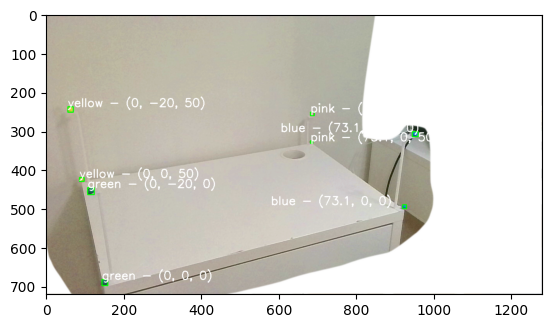

In [49]:
camera_pose_from_img(IMAGE_PATH_R)

In [50]:
def compute_relative_rotation(rvecs1, rvecs2):
    # Convert rotation vectors to rotation matrices
    R1, _ = cv2.Rodrigues(rvecs1)
    R2, _ = cv2.Rodrigues(rvecs2)

    # Compute the relative rotation matrix
    relative_rotation_matrix = np.dot(R2, np.linalg.inv(R1))

    # Convert the relative rotation matrix to a rotation vector
    relative_rotation_vector, _ = cv2.Rodrigues(relative_rotation_matrix)

    return relative_rotation_vector

In [51]:
def estimate_relative_transform(fnL, fnR, camera_params_l, camera_params_r, l_image=None, r_image=None):
  r = np.zeros((3,1))
  t = np.zeros((3,1))
  n=1

  l_file = fnL if l_image is None else l_image
  r_file = fnR if r_image is None else r_image

  image = cv2.imread(l_file)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  points_2d, points_3d = detect_2d_3d_points(image, show_img=False)

  Rl_, tl_, rl_ = estimate_camera_pose(points_2d, points_3d, camera_params_l)

  image = cv2.imread(r_file)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  points_2d, points_3d = detect_2d_3d_points(image, show_img=False)

  Rr_, tr_, rr_ = estimate_camera_pose(points_2d, points_3d, camera_params_r)

  rel_rot = rr_-rl_ #compute_relative_rotation(rl_, rr_)
  #print(f"relrot: {rel_rot}")
  tdiff = -(tr_ - tl_)
  rdiff = -rel_rot

  r += rdiff
  t += tdiff

  r=r/n
  t=t/n
  #print(r)
  #print(t)
  return r*360/(2*math.pi), t

In [52]:
estimate_relative_transform(IMAGE_PATH_L, IMAGE_PATH_R, params_l, params_r)

{'orange': [], 'green': [(272, 644, 15, 14, 0.7854492476904195, 164.94434201498808), (252, 410, 12, 12, 0.5249243468315876, 75.58910594374862)], 'yellow': [(190, 384, 10, 10, 0.7210679277478591, 72.10679277478592), (168, 205, 10, 11, 0.8005875528566128, 88.0646308142274)], 'purple': [], 'blue': [(1026, 468, 12, 12, 0.6741964435272076, 97.08428786791791), (1062, 277, 16, 14, 0.749590548094682, 167.90828277320875)], 'pink': [(768, 298, 8, 6, 0.6751743232802278, 32.408367517450934), (772, 224, 8, 8, 0.7025148802751698, 44.96095233761087)]}
{'orange': [], 'green': [(144, 682, 15, 16, 0.7966094623810117, 191.1862709714428), (107, 446, 17, 18, 0.7942346971660448, 243.0358173328097)], 'yellow': [(86, 420, 12, 10, 0.7834984145714698, 94.01980974857638), (56, 238, 14, 14, 0.7257112859468875, 142.23941204558994)], 'purple': [], 'blue': [(920, 490, 10, 10, 0.7769863244097859, 77.69863244097859), (945, 302, 15, 13, 0.6435552913113908, 125.4932818057212)], 'pink': [(682, 326, 6, 6, 0.74439093792074

/var/folders/yr/pvjq_ntj5tjf0860xxz55spr0000gn/T/ipykernel_56326/3849558073.py:34: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 370 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  lower_bound = np.array(color_lower, dtype=np.uint8)
/var/folders/yr/pvjq_ntj5tjf0860xxz55spr0000gn/T/ipykernel_56326/3849558073.py:35: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 420 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  upper_bound = np.array(color_upper, dtype=np.uint8)


(array([[1.31487396],
        [1.59047316],
        [0.28373395]]),
 array([[ 9.32318798],
        [-2.7183669 ],
        [ 0.93837535]]))

In [14]:
def estimate_relative_pose(left_poses, right_poses):
    """
    Estimate the relative pose (rotation and translation) between two cameras.

    Args:
    - left_poses: List of camera poses for the left camera, each pose is a tuple (R, T),
                  where R is the rotation matrix and T is the translation vector.
    - right_poses: List of camera poses for the right camera, corresponding to the left poses.

    Returns:
    - R: Rotation matrix representing the relative rotation between the cameras.
    - T: Translation vector representing the relative translation between the cameras.
    """

    # Check if the number of left and right poses match
    if len(left_poses) != len(right_poses):
        raise ValueError("Number of left and right poses should be the same.")

    num_poses = len(left_poses)

    # Accumulate the rotation and translation differences
    R_accumulated = np.zeros((3, 3))
    T_accumulated = np.zeros((3, 1))

    for i in range(num_poses):
        # Get the rotation and translation for the current pair of poses
        R_left, T_left = left_poses[i]
        R_right, T_right = right_poses[i]

        # Compute the relative rotation and translation
        R_relative = R_right @ R_left.T  # Rotation difference
        T_relative = T_right - R_relative @ T_left  # Translation difference

        # Accumulate the relative rotation and translation differences
        R_accumulated += R_relative
        T_accumulated += T_relative

    # Compute the average relative rotation and translation
    R = R_accumulated / num_poses
    T = T_accumulated / num_poses

    return R, T